
# Overview:

This script implements an end‐to‐end exercise to predict whether a patient has diabetes using neural networks in both Keras and PyTorch.
It begins with thorough EDA and feature engineering, followed by advanced preprocessing steps including SMOTE for class balancing, PCA and LDA for dimensionality reduction, and polynomial feature expansion.
Two model definitions (Keras and PyTorch) are provided, and Keras Tuner is employed to perform automated hyperparameter search on the Keras network.
Finally, model performance is evaluated and compared across frameworks to determine the optimal approach.



## Import the Librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import math
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

## Load the data:

### Dataset

For this project, we’ll work with the Pima Indians Diabetes dataset from the UCI Machine Learning Repository. It comprises clinical measurements collected from female Pima Indian patients, along with a binary label indicating whether each individual developed diabetes within five years. With 768 samples in total, this is a classic binary classification problem. All predictors are numerical but span different scales, so thoughtful preprocessing is important. The eight input features are:

1. Number of pregnancies  
2. Plasma glucose concentration two hours after an oral glucose tolerance test  
3. Diastolic blood pressure (mm Hg)  
4. Triceps skinfold thickness (mm)  
5. Two-hour serum insulin (μU/ml)  
6. Body mass index (BMI)  
7. Diabetes pedigree function  
8. Age (years)  

The target column denotes diabetes onset (1) or absence (0) within five years.  


In [4]:
diabetes = pd.read_csv('pima-indians-diabetes.csv')
primera_fila = pd.DataFrame([diabetes.columns.tolist()], columns=diabetes.columns)
diabetes = pd.concat([primera_fila, diabetes], ignore_index=True)
l = ['N Embarazos' , 'Glucosa' , 'P Arterial' , 'Grosor Piel' , 'Insulina' , 'IMC' , 'Pedigri' , 'Edad' , 'Clase']
diabetes.columns = l
diabetes

,N Embarazos,Glucosa,P Arterial,Grosor Piel,Insulina,IMC,Pedigri,Edad,Clase
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.34,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1



## Check for Missing values

In [6]:
for i in diabetes.columns:
    if diabetes[i].isna().sum() > 0:
        print('Datos Faltantes en {i}')
    else:
        pass 
else:
    print('No hay datos faltantes')    


No hay datos faltantes


## Check if there is any unbalanced class:

In [7]:
for i in diabetes.columns:
    diabetes[i] = diabetes[i].astype(float) # Change all the types to float in case there is some str


diabetes['Clase'].value_counts()


Clase
0.0    500
1.0    268
Name: count, dtype: int64

## Check if there is data that cannot be real:

In [8]:
(diabetes == 0).sum()

N Embarazos    111
Glucosa          5
P Arterial      35
Grosor Piel    227
Insulina       374
IMC             11
Pedigri          0
Edad             0
Clase          500
dtype: int64

### As you can see in the BMI column, for example, **this cannot be 0** in real life, and the same goes for blood pressure and skin thickness...
### So, let's assume this data is Nan and implement some method to fill in missing data.


In [9]:
variables_clave = ['Glucosa' , 'P Arterial' , 'Grosor Piel' , 'Insulina' , 'IMC']

for i in diabetes.columns:
    if i in variables_clave:
        diabetes.loc[diabetes[i] == 0 , i] = np.nan 
    else:
        pass 



### There should be the same number of Nans as we had of 0 in the key columns

In [10]:
diabetes.isna().sum()

N Embarazos      0
Glucosa          5
P Arterial      35
Grosor Piel    227
Insulina       374
IMC             11
Pedigri          0
Edad             0
Clase            0
dtype: int64

## KNN imputer 

In [11]:

numericas = ['N Embarazos' , 'Glucosa' , 'P Arterial' , 'Grosor Piel' , 'Insulina' , 'IMC' , 'Pedigri' , 'Edad' , 'Clase']
imputar = ['Glucosa' , 'P Arterial' , 'Grosor Piel' , 'Insulina' , 'IMC']


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=3, weights='uniform'))]) ## 3 neighbors for complete the missing data

X_scaled_imputed = pipeline.fit_transform(diabetes)

# Restore the original scale
scaler = pipeline.named_steps['scaler']
X_imputed = scaler.inverse_transform(X_scaled_imputed)

base_imputada = pd.DataFrame(X_imputed,columns=numericas,index=diabetes.index)

diabetes = diabetes.copy()
diabetes[imputar] = base_imputada[imputar]

### We can verify that there is no more missing data:

In [12]:
diabetes.isna().sum()

N Embarazos    0
Glucosa        0
P Arterial     0
Grosor Piel    0
Insulina       0
IMC            0
Pedigri        0
Edad           0
Clase          0
dtype: int64


### There is also no data that is 0 in the key columns:

In [13]:
(diabetes == 0).sum()

N Embarazos    111
Glucosa          0
P Arterial       0
Grosor Piel      0
Insulina         0
IMC              0
Pedigri          0
Edad             0
Clase          500
dtype: int64

## Exploratory Data Analysis

### Histograms:

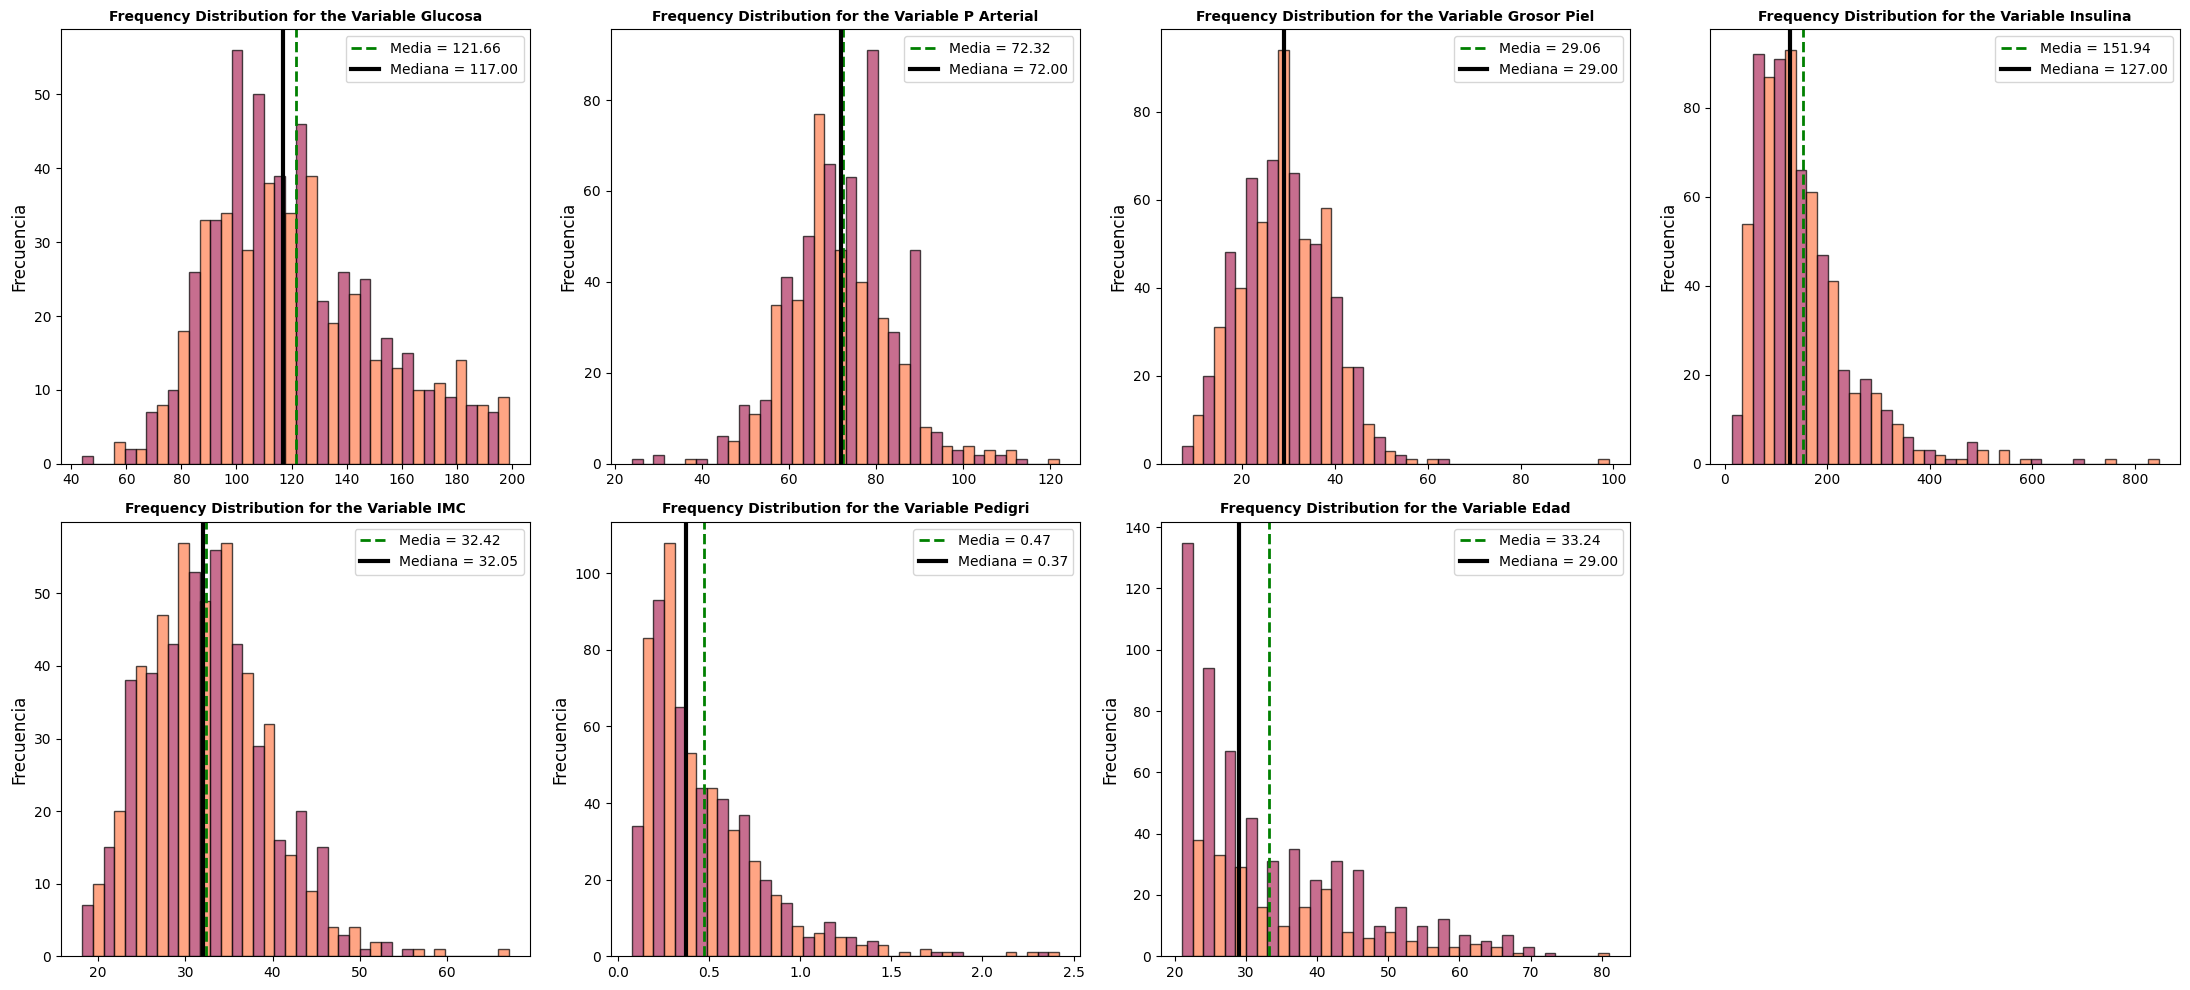

In [14]:

def histograma(var , name , ax):
    media = var.mean()
    mediana = var.median()
    colors = ['#B03060', '#FF7F50']

    n, bins, patches = ax.hist(var, bins=40, alpha=0.7, edgecolor='black')

    for i, patch in enumerate(patches):
        patch.set_facecolor(colors[i % len(colors)])

    ax.axvline(x=media, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media:,.2f}')
    ax.axvline(x=mediana, color='black', linestyle='-', linewidth=3, label=f'Mediana = {mediana:,.2f}')
    ax.legend()
    ax.set_title(f'Frequency Distribution for the Variable {name}', fontsize= 10, weight='bold')
    ax.set_ylabel('Frecuencia', fontsize=12)

    return ax

var_numericas = ['Glucosa' , 'P Arterial' , 'Grosor Piel' , 'Insulina' , 'IMC' , 'Pedigri' , 'Edad' ]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 10))
axes_flat = axes.flatten()

for idx, var in enumerate(var_numericas):
    histograma(diabetes[var], var, ax=axes_flat[idx])
axes_flat[len(var_numericas)].axis('off')

fig.tight_layout()
plt.show()

### BoxPlots:

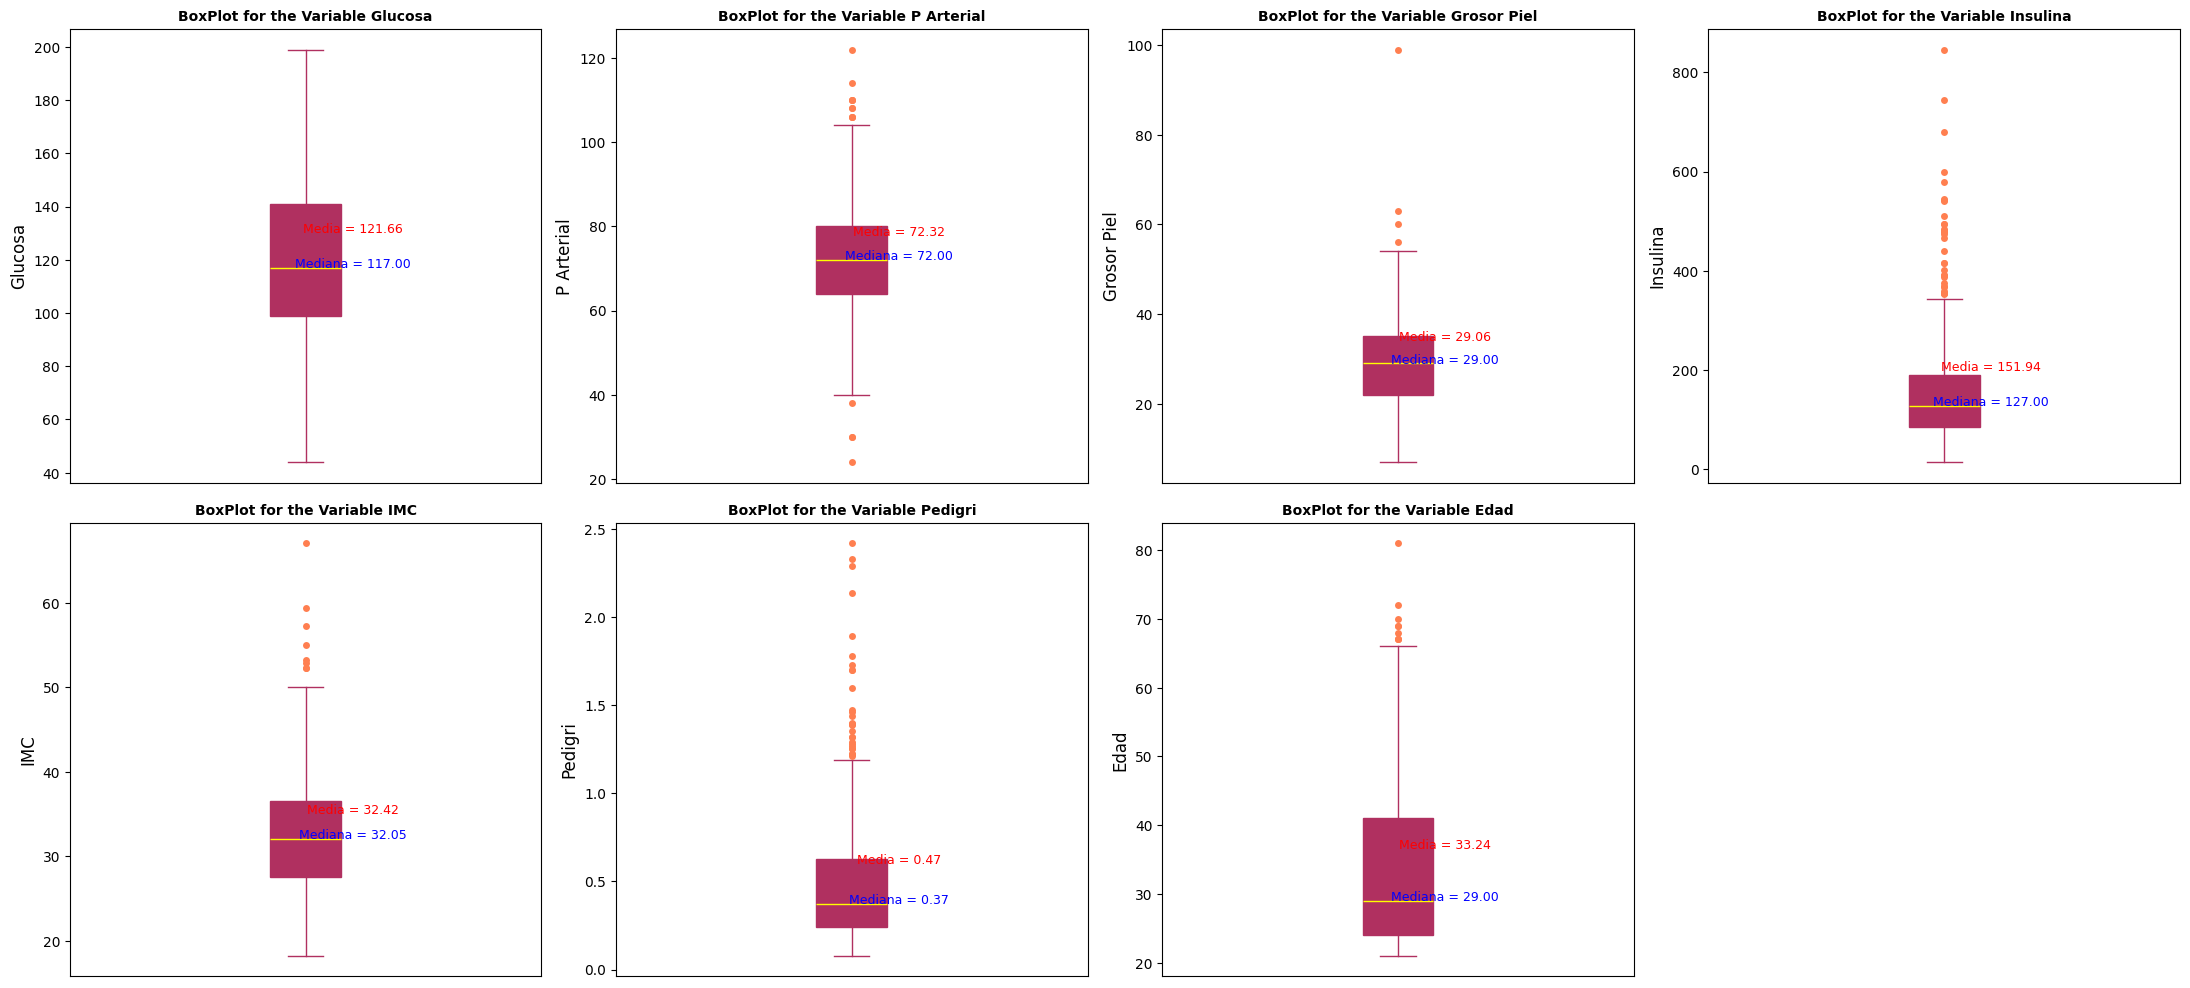

In [15]:
def boxplot_var(var, name, ax):
    media = var.mean()
    mediana = var.median()

    box = ax.boxplot(var.dropna(),vert=True,patch_artist=True,
        boxprops=dict(facecolor='#B03060', color='#B03060'),
        medianprops=dict(color='yellow'),
        whiskerprops=dict(color='#B03060'),
        capprops=dict(color='#B03060'),
        flierprops=dict(marker='o', markerfacecolor='#FF7F50', markersize=5, linestyle='none', markeredgecolor='none'))
    
    ax.set_title(f'BoxPlot for the Variable {name}', fontsize=10, weight='bold')
    ax.set_ylabel(name, fontsize=12)

    ylim = ax.get_ylim()
    y_mean = media + (ylim[1] - ylim[0]) * 0.05
    y_med = mediana
    ax.text(1.1, y_mean, f'Media = {media:,.2f}', horizontalalignment='center', color='red', fontsize=9)
    ax.text(1.1, y_med, f'Mediana = {mediana:,.2f}', horizontalalignment='center', color='blue', fontsize=9)
    ax.set_xticks([])  
    return ax

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 10))
axes_flat = axes.flatten()

for idx, var in enumerate(var_numericas):
    boxplot_var(diabetes[var], var, ax=axes_flat[idx])
axes_flat[len(var_numericas)].axis('off')
fig.tight_layout()
plt.show()


### Pearson Correlation 

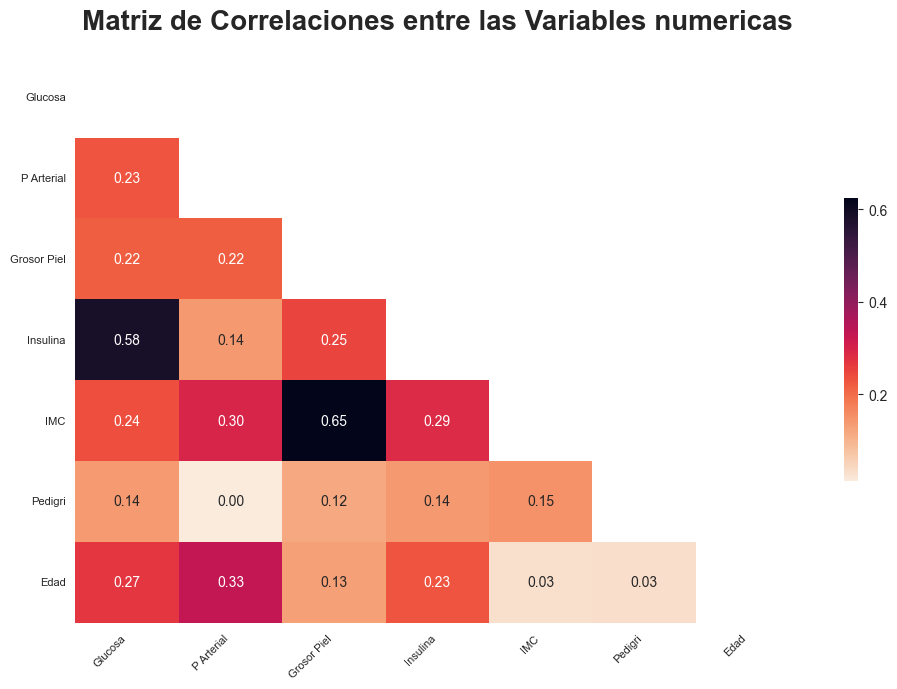

In [16]:
base_numericas = diabetes[var_numericas]

correlation_matrix = base_numericas.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
with sns.axes_style("white"):
    with sns.plotting_context(font_scale=0.8):
        plt.figure(figsize=(10, 7))
        sns.heatmap(correlation_matrix, mask=mask, cmap='rocket_r' , annot=True, fmt=".2f", robust=True, linecolor='white',
            cbar_kws={"shrink": .5, "ticks": np.linspace(-1, 1, 11)},)
        plt.title('Matriz de Correlaciones entre las Variables numericas', fontsize=20, weight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()



### Scatter Plots

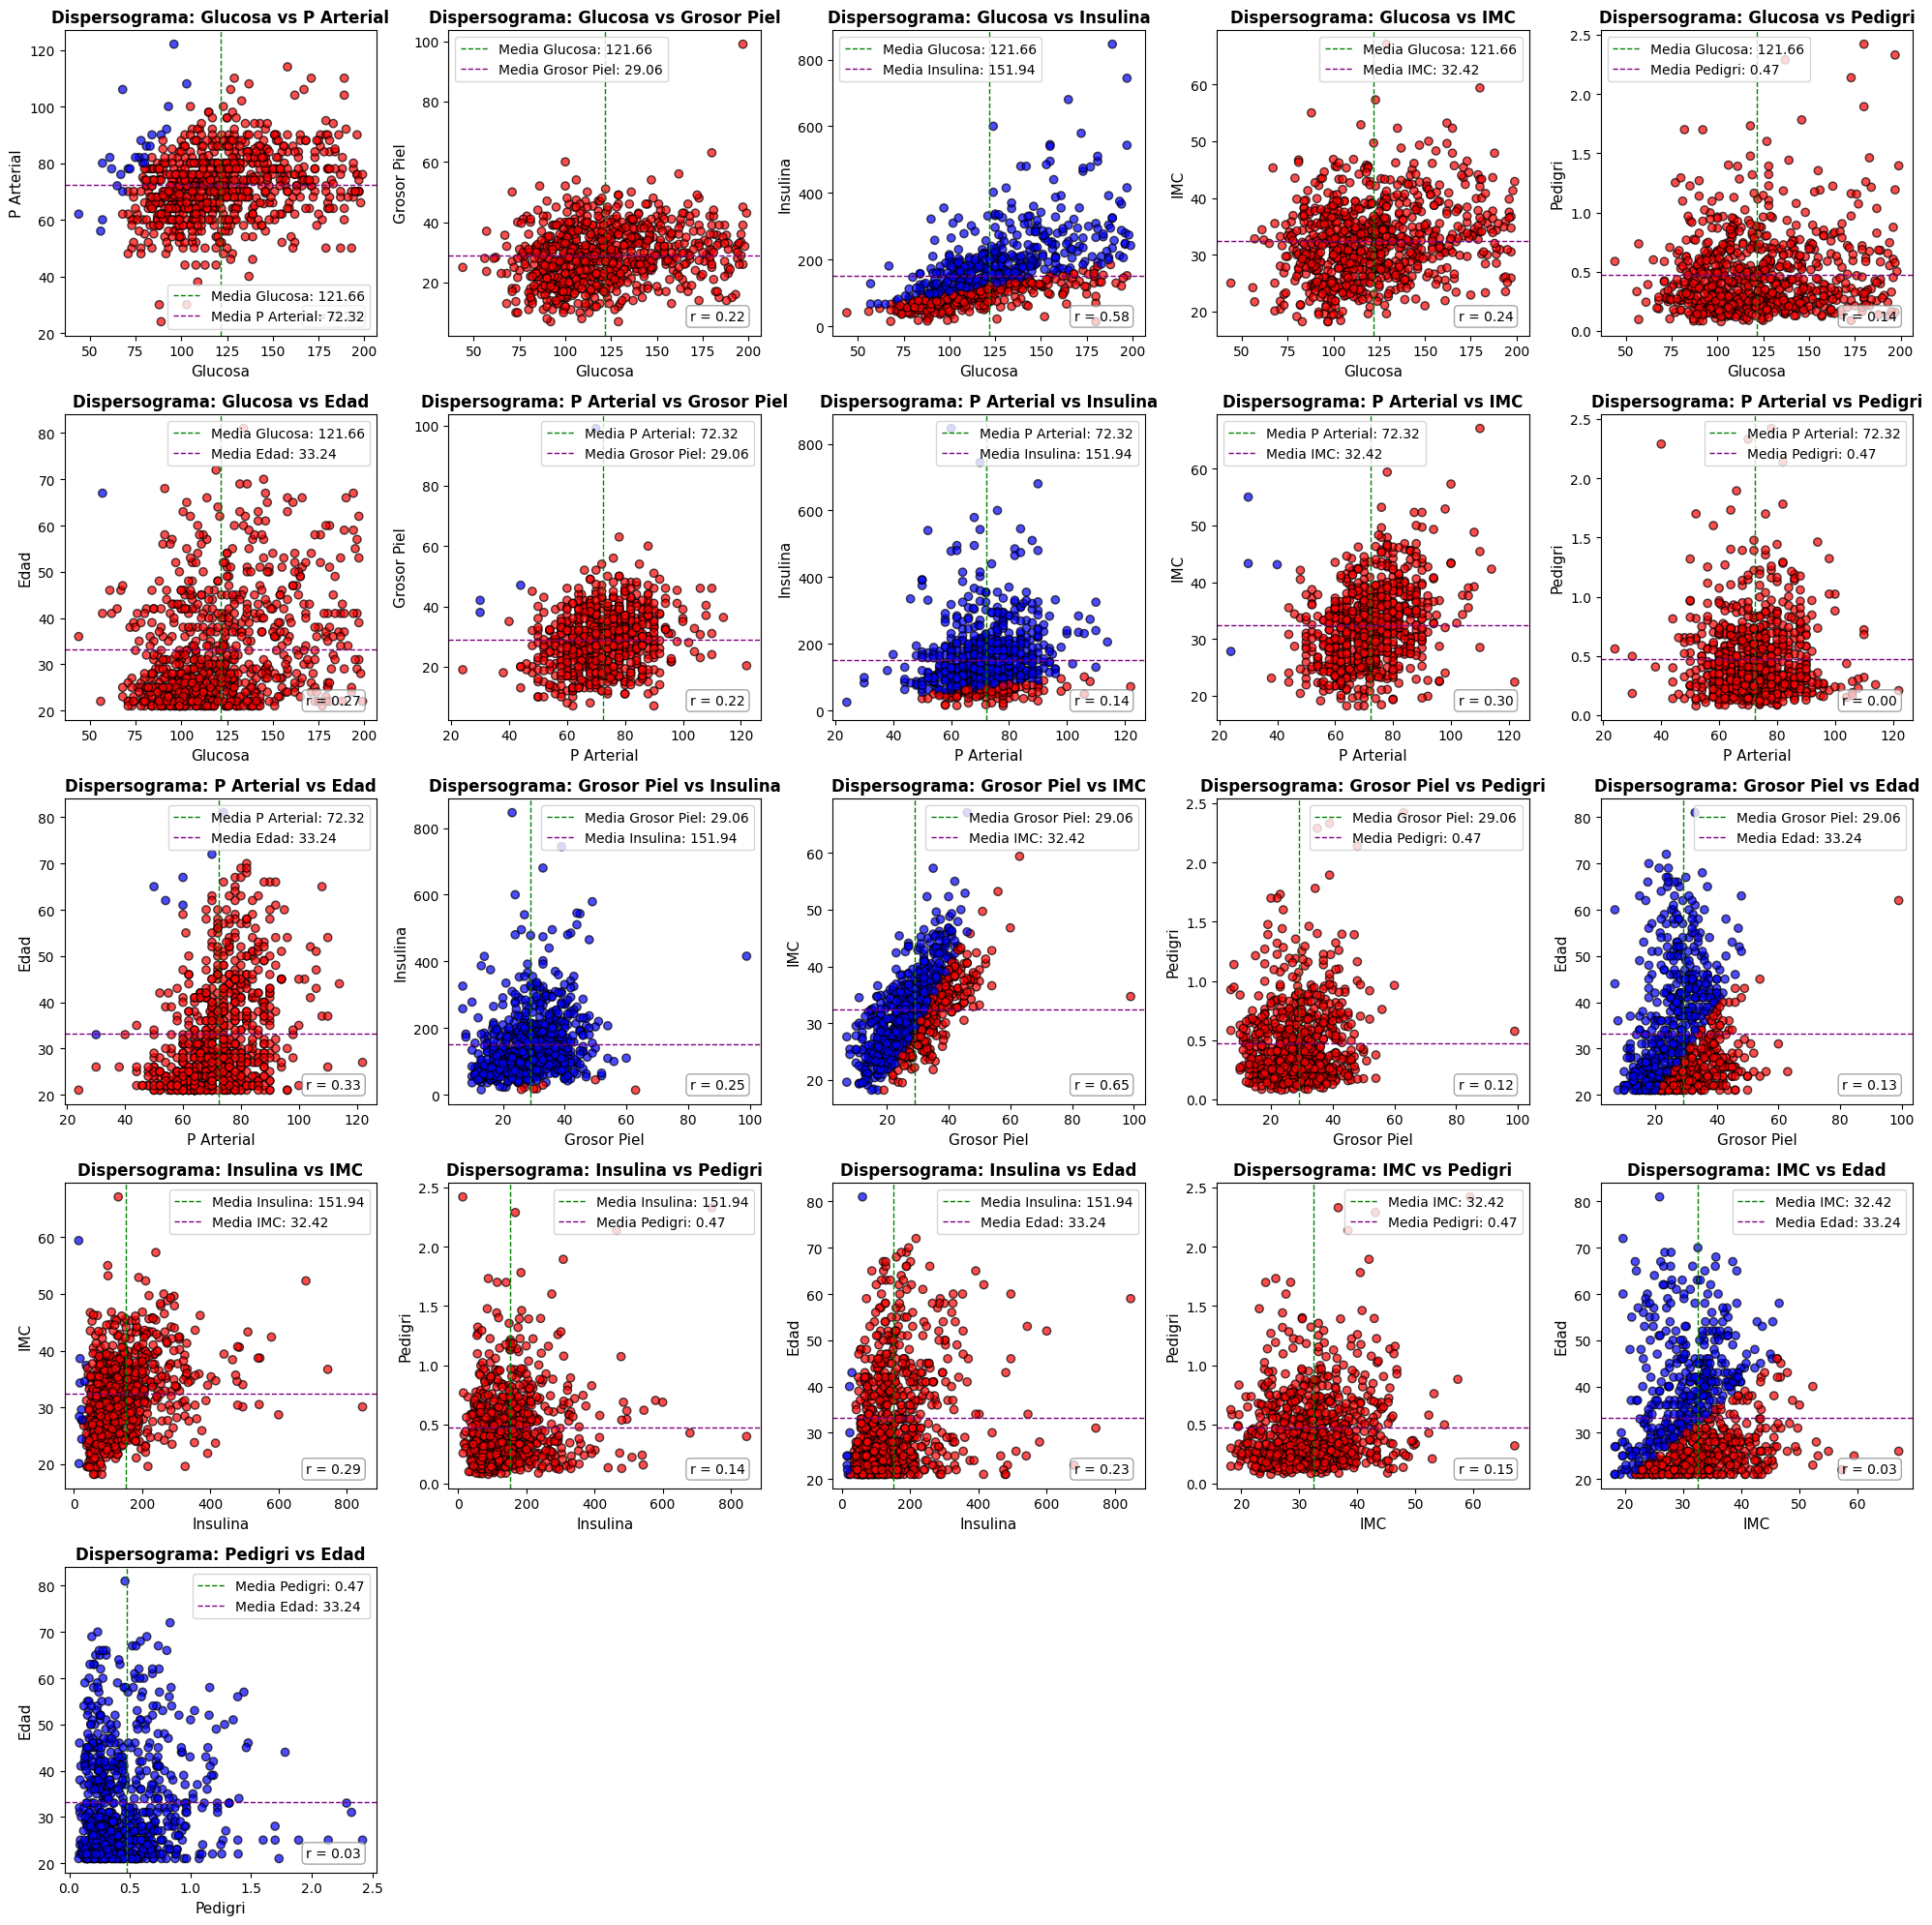

In [15]:
import itertools

def dispersograma(x, y, name_x, name_y, ax):
    mean_x, mean_y = x.mean(), y.mean()
    corr = x.corr(y)
    colors = ['red' if xi > yi else 'blue' for xi, yi in zip(x, y)]

    ax.scatter(x, y,  c=colors, alpha=0.7, edgecolor='black')
    ax.axvline(mean_x, color='green', linestyle='dashed', linewidth=1, label=f'Media {name_x}: {mean_x:,.2f}')
    ax.axhline(mean_y, color='purple', linestyle='dashed', linewidth=1, label=f'Media {name_y}: {mean_y:,.2f}')
    
    ax.set_title(f'Dispersograma: {name_x} vs {name_y}', fontsize=12, weight='bold')
    ax.set_xlabel(name_x, fontsize=11)
    ax.set_ylabel(name_y, fontsize=11)
    
    ax.text(0.95, 0.05,f'r = {corr:.2f}',transform=ax.transAxes,
        horizontalalignment='right',fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))
    ax.legend()
    return ax


combos = list(itertools.combinations(var_numericas, 2))
n_plots = len(combos)
cols = 5
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for idx, (x_var, y_var) in enumerate(combos):
    dispersograma(diabetes[x_var], diabetes[y_var], x_var, y_var, ax=axes[idx])

for ax in axes[n_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Q-Q plots and Normality test

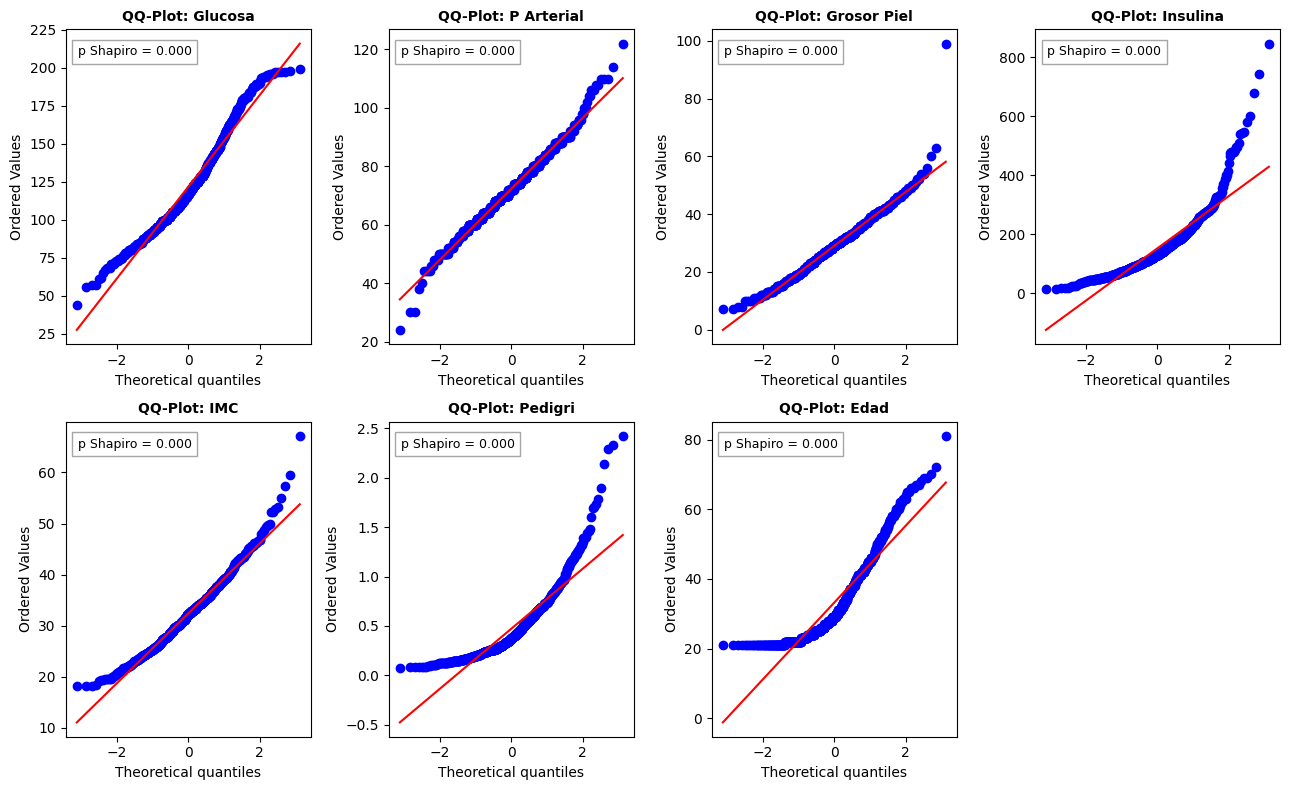

In [64]:
from scipy import stats

def qqplot(var, name, ax):
    data = var.dropna()
    stat, p_value = stats.shapiro(data)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f'QQ-Plot: {name}', fontsize=10, weight='bold')

    ax.text(0.05, 0.95,f'p Shapiro = {p_value:.3f}',
        transform=ax.transAxes,verticalalignment='top',fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    return ax

fig, axes = plt.subplots(2, 4, figsize=(13, 8))
axes_flat = axes.flatten()

for idx, var in enumerate(var_numericas):
    qqplot(diabetes[var], var, ax=axes_flat[idx])

axes_flat[len(var_numericas)].axis('off')

fig.tight_layout()
plt.show()

## Feature Engineering

In [12]:
from sklearn.cluster import KMeans

eps = np.finfo(float).eps

## Differentiable Numerical Indices
diabetes['glucosa-presion'] = diabetes['Glucosa'] / (diabetes['P Arterial'] + eps)
diabetes['HOMA_IR'] = (diabetes['Glucosa'] * diabetes['Insulina']) / 405
diabetes['glucosa_alta'] = (diabetes['Glucosa'] > 126).astype(int) * diabetes['Glucosa']
diabetes['ISI'] = 1/(np.log(diabetes['Insulina']+1) +np.log(diabetes['Glucosa']+1))
diabetes['piel_IMC'] = diabetes['Grosor Piel'] / (diabetes['IMC'] + eps)
diabetes['INS_piel'] = diabetes['Insulina'] / (diabetes['Grosor Piel'] + eps)
diabetes['insulina-IMC'] = diabetes['Insulina'] / (diabetes['IMC'] + np.finfo(float).eps)
diabetes['Embarazos Rtv'] = diabetes['N Embarazos'] / diabetes['Edad'] 
diabetes['Insulina_alta'] = diabetes['Insulina'] > 250
diabetes['score_riesgo'] = ((diabetes['Glucosa'] > 126).astype(int) +
    (diabetes['IMC'] > 30).astype(int) +(diabetes['Edad'] > 50).astype(int) +(diabetes['Insulina_alta']).astype(int))


## Derivable Categorical Indices
diabetes['Rango Edad'] = pd.cut(diabetes['Edad'], bins=[0, 30, 50, 105], labels=['Joven', 'Mediana Edad', 'Adulto Mayor'],right=True)
diabetes['Tolerancia Glucosa'] = pd.cut(diabetes['Glucosa'], bins=[0, 100, 130, float('inf')], labels=['Normal', 'Pre Diabetes', 'Diabetes Pot'],right=True)
diabetes['Categoria_IMC'] = pd.cut(diabetes['IMC'],bins=[0, 18.5, 25, 30, float('inf')],
    labels=['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad'],
    right=False)


## Transform data to smooth heavy tails seen in BoxPlot
diabetes['Insulina'] = np.log(diabetes['Insulina'] + 1)
diabetes['Pedigri'] = np.log(diabetes['Pedigri'] + 1)



# Clustering algorithms for an extra variable
numeric_features = ['N Embarazos', 'Glucosa', 'P Arterial', 'Grosor Piel', 'Insulina', 'IMC', 'Pedigri', 'Edad', 'glucosa-presion', 'insulina-IMC',
       'Embarazos Rtv', 'score_riesgo' , 'HOMA_IR' , 'ISI'  , 'piel_IMC'  , 'INS_piel' ,'glucosa_alta' ]
km = KMeans(n_clusters=3, random_state=9)
diabetes['cluster'] = km.fit_predict(StandardScaler().fit_transform(diabetes[numeric_features]))


diabetes

C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,N Embarazos,Glucosa,P Arterial,Grosor Piel,Insulina,IMC,Pedigri,Edad,Clase,glucosa-presion,...,piel_IMC,INS_piel,insulina-IMC,Embarazos Rtv,Insulina_alta,score_riesgo,Rango Edad,Tolerancia Glucosa,Categoria_IMC,cluster
0,6.0,148.0,72.0,35.000000,5.713733,33.6,0.486738,50.0,1.0,2.055556,...,1.041667,8.628571,8.988095,0.120000,True,3,Mediana Edad,Diabetes Pot,Obesidad,2
1,1.0,85.0,66.0,29.000000,4.025352,26.6,0.300845,31.0,0.0,1.287879,...,1.090226,1.896552,2.067669,0.032258,False,0,Mediana Edad,Normal,Sobrepeso,1
2,8.0,183.0,64.0,35.666667,5.351858,23.3,0.514021,32.0,1.0,2.859375,...,1.530758,5.887850,9.012876,0.250000,False,1,Mediana Edad,Diabetes Pot,Normal,2
3,1.0,89.0,66.0,23.000000,4.553877,28.1,0.154436,21.0,0.0,1.348485,...,0.818505,4.086957,3.345196,0.047619,False,0,Joven,Normal,Sobrepeso,1
4,0.0,137.0,40.0,35.000000,5.129899,43.1,1.190279,33.0,1.0,3.425000,...,0.812065,4.800000,3.897912,0.000000,False,2,Mediana Edad,Diabetes Pot,Obesidad,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,5.198497,32.9,0.157858,63.0,0.0,1.328947,...,1.458967,3.750000,5.471125,0.158730,False,2,Adulto Mayor,Pre Diabetes,Obesidad,0
764,2.0,122.0,70.0,27.000000,4.809471,36.8,0.292670,27.0,0.0,1.742857,...,0.733696,4.506173,3.306159,0.074074,False,1,Joven,Pre Diabetes,Obesidad,1
765,5.0,121.0,72.0,23.000000,4.727388,26.2,0.219136,30.0,0.0,1.680556,...,0.877863,4.869565,4.274809,0.166667,False,0,Joven,Pre Diabetes,Sobrepeso,1
766,1.0,126.0,60.0,26.333333,4.870095,30.1,0.299364,47.0,1.0,2.100000,...,0.874862,4.911392,4.296788,0.021277,False,1,Mediana Edad,Pre Diabetes,Obesidad,1


## Save this created base

In [14]:
diabetes.to_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Vida Profesional\\Semillero\\Diabetes_1.csv', index=False)

## Data Preprocessing:

In [49]:
from sklearn.decomposition import PCA

X = diabetes.drop(columns=['Clase'])
y = diabetes['Clase']

numeric_features = ['N Embarazos', 'Glucosa', 'P Arterial', 'Grosor Piel', 'Insulina', 'IMC', 'Pedigri', 'Edad', 'glucosa-presion', 'insulina-IMC',
       'Embarazos Rtv', 'score_riesgo' , 'HOMA_IR' , 'ISI'  , 'piel_IMC'  , 'INS_piel'  ,'glucosa_alta' ,'cluster']
categorical_features = ['Insulina_alta' , 'Rango Edad','Tolerancia Glucosa', 'Categoria_IMC']

# For numeric variables we will use StandardScaler, for categorical variables OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='drop')

## Let's make a second degree polynomial combination of all the already scaled features. 
## In the database we created, there were 28 variables, which means there will be at least 289 columns created by PolynomialFeatures. 
## In reality, there are more because OneHotEncoder creates columns for the categorical variables. 
## To avoid overfitting due to so many variables, we'll use PCA and only use the 63 principal components of all those created with PolynomialFeatures.
## *This 63 comes from trial and error with the model, it was the maximum number of variables that we could include without overfitting.*
pipe = Pipeline([
    ('preproc', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=63, random_state=9))])

X_poly = pipe.fit_transform(X)

## Now lets split the data into test-trai
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, stratify=y)

## Now let's balance the classes in the training set using a SMOTE
smote = SMOTE(random_state=9)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

## Finally, let's perform a LinearDiscriminantAnalysis to project the data to the subspace that most separates the two classes.
lda = LinearDiscriminantAnalysis()
X_train_final = lda.fit_transform(X_train_bal, y_train_bal)
X_test_final  = lda.transform(X_test)

### We can see that the training data is balanced.

In [50]:
y_train_bal.value_counts()

Clase
0.0    400
1.0    400
Name: count, dtype: int64

### We can also see that thanks to LDA the projection is done in a single vector, this means that we go from having 63 variables created with PolynomialFeatures to a simple vector that contains all the information of the variables projected in a subspace where the classes are as far as possible separable.

In [51]:
print(X_train_final.shape , y_train_bal.shape)
print(X_test_final.shape , y_test.shape)

(800, 1) (800,)
(154, 1) (154,)


## For the Keras neural network we are going to use KerasTuner, then we create the possible exploration grid of the model:

In [17]:
def crear_modelo(hp):
    modelo = tf.keras.Sequential()
    modelo.add(tf.keras.layers.Input(shape=(X_train_final.shape[1],))) ## Always a input layer same size as our data
    
    num_capas = hp.Int("num_layers", min_value=1, max_value=20, step=5) ## We are going to have 1 to 20 dense layers in steps of 5 to 5 
    
    for i in range(num_capas):

        unidades = hp.Int(f"units_{i}", min_value=10, max_value=100, step=5) ## In every layer we are going to have min 10 or max 100 neurons

        modelo.add(tf.keras.layers.Dense(units=unidades, use_bias=False)) 

        modelo.add(tf.keras.layers.BatchNormalization()) ## In every layer we applay a Batch Normalization layer so that the network is more constant

        activacion = hp.Choice(f"activation_{i}", values=['relu', 'sigmoid', 'tanh']) ## Each layer will have as activation function a relu, sigmoid or tanh

        modelo.add(tf.keras.layers.Activation(activacion))
        
        dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.0,
                                max_value=0.5, step=0.1, default=0.0) ## For regularization we will apply dropout layers randomly
        if dropout_rate > 0.0:
            modelo.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    modelo.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) ## Since it is a binary classification problem, the output layer will ALWAYS be a sigmoid.
    
    hp_lr = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001, 1e-5]) ## You can play with the learning rate
    
    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(), ## We use adam as an optimizer
        loss='binary_crossentropy', ## And the loss function is binary crossentropy due to the nature of the problem
        metrics=["accuracy"]) 
    
    return modelo


### Let's do a hyperparameter optimization also on the number of epochs and batch size

In [18]:
import keras_tuner 

class MiHyperModel(keras_tuner.HyperModel):
    def build(self, hp): # This method receives and return the model we created above.
        modelo = crear_modelo(hp)
        return modelo

    def fit(self, hp, model, *args, **kwargs):
        # Define hyperparameters for batch_size and epochs
        batch_size = hp.Choice("batch_size", values=[64, 128, 256, 500])
        epochs = hp.Int("epochs", min_value=20, max_value=150, step=20, default=30)
        kwargs['batch_size'] = batch_size
        kwargs['epochs'] = epochs
        
        return model.fit(*args, **kwargs)

hypermodel = MiHyperModel()

### Random Search 

In [55]:

tuner = keras_tuner.RandomSearch(
    hypermodel= hypermodel,  
    objective=keras_tuner.Objective("accuracy",  "max"), ## The goal will be the highest accuracy
    max_trials=10, executions_per_trial=2 ,directory="afinacion_red",project_name="trials", overwrite = False ,seed=9)

## We also defined an early stop that monitored the loss of the models to not waste time on models.
early_stop = EarlyStopping(monitor='loss', patience=17 , verbose=1 ,restore_best_weights = False)

tuner.search(
    X_train_final,
    y_train_bal,
    validation_data=(X_test_final, y_test),
    callbacks=[early_stop])

Trial 10 Complete [00h 00m 11s]
accuracy: 0.8575000166893005

Best accuracy So Far: 0.8612499833106995
Total elapsed time: 00h 02m 17s


## Display the best model found

In [56]:
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               100       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 601 (2.35 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 200 (800.00 Byte)
______________________

## Classification Report and ROC Curve

5/5 [==============================] - 0s 0s/step
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       100
         1.0       0.70      0.80      0.75        54

    accuracy                           0.81       154
   macro avg       0.79      0.81      0.80       154
weighted avg       0.82      0.81      0.81       154



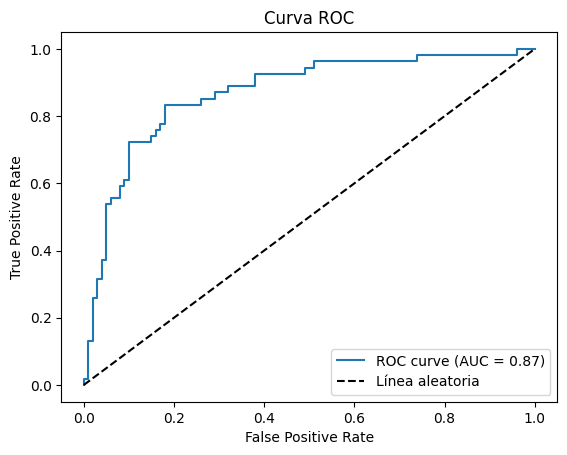

In [57]:

from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = mejor_modelo.predict(X_test_final).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Neural Netork With Pytorch

### In my case I have Pytorch and TensorFlow in different python environments, so I have to run the preprocessing again.

In [2]:
diabates1 = pd.read_csv('Diabetes_1.csv')

In [129]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

X = diabates1.drop(columns=['Clase'])
y = diabates1['Clase']

numeric_features = ['N Embarazos', 'Glucosa', 'P Arterial', 'Grosor Piel', 'Insulina', 'IMC', 'Pedigri', 'Edad', 'glucosa-presion', 'insulina-IMC',
       'Embarazos Rtv', 'score_riesgo' , 'HOMA_IR' , 'ISI'  , 'piel_IMC'  , 'INS_piel'  ,'glucosa_alta' ,'cluster']

categorical_features = ['Insulina_alta' , 'Rango Edad','Tolerancia Glucosa', 'Categoria_IMC']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='drop')

pipe = Pipeline([
    ('preproc', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=63, random_state=9))])

X_poly = pipe.fit_transform(X)

#Initial Split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_poly, y, test_size=0.20, stratify=y,random_state=42)

# Split train vs val within the remaining 80% → 60%/20%/20% total
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,test_size=0.25,stratify=y_temp,random_state=42)

smote = SMOTE(random_state=9)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

lda = LinearDiscriminantAnalysis()
X_train_final = lda.fit_transform(X_train_bal, y_train_bal)
X_val_final   = lda.transform(X_val)
X_test_final  = lda.transform(X_test)


### For pytorch we created a different split... where we now have train (60%), validation(20%) and testing(20%) sets

In [130]:
print(X_train_final.shape , y_train_bal.shape)
print(X_val_final.shape , y_val.shape)
print(X_test_final.shape , y_test.shape)

(600, 1) (600,)
(154, 1) (154,)
(154, 1) (154,)


## Pytorch Librarys:

In [31]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split


### Convert Arrays and DataFrames to Tensosrs

In [133]:
X_train_tensor = torch.from_numpy(X_train_final).float() 
y_train_tensor = torch.tensor(y_train_bal.values.squeeze(), dtype=torch.long) 

X_val_tensor = torch.from_numpy(X_val_final).float() 
y_val_tensor = torch.tensor(y_val.values.squeeze(), dtype=torch.long) 

X_test_tensor  = torch.from_numpy(X_test_final).float() 
y_test_tensor  = torch.tensor(y_test.values.squeeze(), dtype=torch.long)

### We can see that our data is now PyTorch Tensor objects.

In [134]:
print(X_train_tensor.shape , y_train_tensor.shape)
print(X_val_tensor.shape , y_val_tensor.shape)
print(X_test_tensor.shape , y_test_tensor.shape)

torch.Size([600, 1]) torch.Size([600])
torch.Size([154, 1]) torch.Size([154])
torch.Size([154, 1]) torch.Size([154])


## Now we will create the TensorDatasets and the DataLoaders:

We create a `TensorDataset` in PyTorch to bundle our input and target tensors into a single, indexable dataset.
By pairing features and labels together, we ensure that each sample remains aligned when we retrieve it by index.

Once the data is wrapped in a `TensorDataset`, we pass it to a `DataLoader` to handle iteration logic automatically.
The `DataLoader` takes care of batching samples into equal‐sized chunks, which simplifies feeding data into our model.
It also supports shuffling the dataset each epoch, preventing the model from learning spurious order patterns.

With built-in support for parallel data loading via worker processes, `DataLoader` speeds up I/O and preprocessing.
Together, these classes decouple data preparation from training loops, making our code cleaner and more modular.
They let us focus on model design while PyTorch efficiently handles indexing, batching, and loading behind the scenes.
This workflow ultimately leads to faster, more reproducible, and more flexible training pipelines.



In [135]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=322, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=322) 
test_loader  = DataLoader(test_ds,batch_size=322)


## Lets Make the NeuralNetwork

### In this case we will not do a hyperparameter optimization, we will only create a network

In [151]:
class RedNeuronal(nn.Module):
    def __init__(self, dim_entrada, neuronas_capas:list, dim_salida = 1):
        super().__init__()

        dimension_total = [dim_entrada] + neuronas_capas + [dim_salida]
        capas: list[nn.Module] = []

        for i in range(len(dimension_total)-2):
            # Hidden Layers
            capas.append(nn.Linear(dimension_total[i], dimension_total[i+1]))
            # As in TensorFlow we add a BatchNormalization layer 
            capas.append(nn.BatchNorm1d(dimension_total[i+1]))
            # Here al the layers are going to have ReLu activation functions
            capas.append(nn.ReLU())
        
        capas.append(nn.Linear(dimension_total[-2], dimension_total[-1])) ## Last Layer 
        capas.append(nn.Sigmoid()) ## Last activation function

        self.net = nn.Sequential(*capas)
    
    ## In this case the forward function is easy because we are using a nn.Sequential
    def forward(self , x):
        return self.net(x)

## The network architecture will be 4 hidden layers with 40, 30, 20 and 10 neurons respectively.
model = RedNeuronal(X_train_tensor.size(1), [40,30,20,10])

## The loss function is again Binary CrossEntropy
criterion = nn.BCELoss() 
## We are using again Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Create functions to train and evaluate

In [152]:
from sklearn.metrics import accuracy_score

def train_epoch(dataloader, model, optimizer, criterion):
    """
    Train the model for one epoch using the provided DataLoader, optimizer, and loss criterion.

    Args:
        dataloader (DataLoader): Iterable over the training dataset, yielding input batches and labels.
        model (nn.Module): The PyTorch model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (callable): Loss function to evaluate model predictions.

    Returns:
        tuple:
            - epoch_accuracy (float): Classification accuracy over the epoch.
            - epoch_loss (float): Average loss per sample over the epoch.
    """
    model.train()  # Set the model to training mode

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for xb, yb in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(xb)

        # Compute the loss (ensure labels have shape [batch_size, 1] and are float)
        loss = criterion(outputs, yb.unsqueeze(1).float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss scaled by batch size
        batch_size = xb.size(0)
        running_loss += loss.item() * batch_size

        # Compute binary predictions (threshold at 0.5), detach and move to CPU
        preds = (outputs > 0.5).long().squeeze().detach().cpu().numpy()
        labels = yb.long().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # Calculate metrics over the entire epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    print(f'Training accuracy: {epoch_acc:.4f}, Training loss: {epoch_loss:.4f}')
    return epoch_acc, epoch_loss


def evaluate(dataloader, model, criterion, return_preds=False):
    """
    Evaluate the model on the given dataset using the provided DataLoader and loss criterion.

    Args:
        dataloader (DataLoader): Iterable over the evaluation dataset, yielding input batches and labels.
        model (nn.Module): The PyTorch model to evaluate.
        criterion (callable): Loss function to compute evaluation loss.
        return_preds (bool, optional): If True, return the raw predictions and labels. Defaults to False.

    Returns:
        tuple:
            - epoch_accuracy (float): Classification accuracy over the evaluation set.
            - epoch_loss (float): Average loss per sample over the evaluation set.
            - all_preds (list[int], optional): Model predictions for each sample (if return_preds=True).
            - all_labels (list[int], optional): True labels for each sample (if return_preds=True).
    """
    model.eval()  # Switch model to evaluation mode

    all_preds = []
    all_labels = []
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            # Forward pass
            outputs = model(xb)

            # Compute loss (ensure labels have shape [batch_size, 1] and are float)
            loss = criterion(outputs, yb.unsqueeze(1).float())

            # Accumulate loss and sample count
            batch_size = xb.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

            # Generate binary predictions (threshold at 0.5)
            preds = (outputs > 0.5).long().squeeze().cpu().numpy()
            labels = yb.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate overall metrics
    epoch_loss = running_loss / total_samples
    epoch_acc = accuracy_score(all_labels, all_preds)

    if not return_preds:
        print(f'Validation accuracy: {epoch_acc:.4f}, Validation loss: {epoch_loss:.4f}')
        return epoch_acc, epoch_loss
    else:
        return epoch_acc, epoch_loss, all_preds, all_labels




## We train the model


In [153]:

epocas = 130

for epoch in range(1, epocas):
    # Training
    print(f'Epoca numero {epoch}')
    entrenamiento_acc , entrenamiento_loss = train_epoch(train_loader , model , optimizer , criterion)
    # Validation
    validacion_acc , validacion_loss = evaluate(val_loader , model , criterion)

    ## Some Kind of early stop if we reach a 0.86 acc
    if entrenamiento_acc > 0.86 and validacion_acc > 0.84:
        break



Epoca numero 1
El accuracy en entrenamiento es: 0.2833333333333333 y el loss 0.8087935749689737
El accuracy en validacion es: 0.18831168831168832 y el loss 0.700884222984314
Epoca numero 2
El accuracy en entrenamiento es: 0.455 y el loss 0.7077057288090388
El accuracy en validacion es: 0.38311688311688313 y el loss 0.695422887802124
Epoca numero 3
El accuracy en entrenamiento es: 0.5533333333333333 y el loss 0.668696460723877
El accuracy en validacion es: 0.2987012987012987 y el loss 0.6951271295547485
Epoca numero 4
El accuracy en entrenamiento es: 0.64 y el loss 0.6387936274210612
El accuracy en validacion es: 0.42207792207792205 y el loss 0.6949594616889954
Epoca numero 5
El accuracy en entrenamiento es: 0.74 y el loss 0.6156211525201798
El accuracy en validacion es: 0.4935064935064935 y el loss 0.6950191855430603
Epoca numero 6
El accuracy en entrenamiento es: 0.775 y el loss 0.602448717157046
El accuracy en validacion es: 0.4675324675324675 y el loss 0.694804847240448
Epoca numero

## Lets See the performance in Test Data:

In [154]:

test_acc, test_loss , predicciones , reales = evaluate(test_loader, model , criterion , return_preds = True)

print(f'Accuracy del test dataset -> {test_acc}')
print(f'Loss del test dataset -> {test_loss}')

Accuracy del test dataset -> 0.7597402597402597
Loss del test dataset -> 0.5166525840759277


## Classification Report and ROC Curve

              precision    recall  f1-score   support

           0     0.8889    0.7200    0.7956       100
           1     0.6164    0.8333    0.7087        54

    accuracy                         0.7597       154
   macro avg     0.7527    0.7767    0.7521       154
weighted avg     0.7934    0.7597    0.7651       154



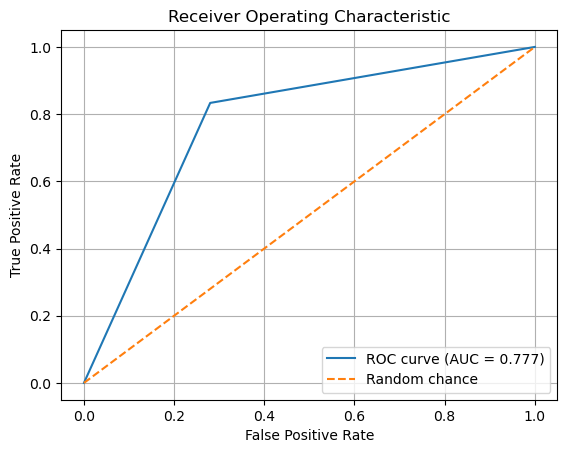

In [161]:
from sklearn.metrics import classification_report, roc_curve, auc

all_preds = [1 if p > 0.5 else 0 for p in predicciones]

print(classification_report(reales, all_preds, digits=4))

fpr, tpr, thresholds = roc_curve(reales, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()